<a href="https://colab.research.google.com/github/bachaudhry/paper_implementations/blob/main/generative_modeling/diffusion/vision/implementing_diffedit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementing DiffEdit**

Key Steps:

1. Provide paper summary with relevant links.
2. List the key steps involved in the DiffEdit implementation.
3. Setup SD pipelines based on NB 9b.
4. Edit segments to generate masks and outputs.
5. Provide fleshed out prose to both explain, while comprehending at the same time, what actually happened.
6. Provide a series of examples with properly animated interpolation of Diffusion steps.
7. References to other implementations.
8. Publish as a blog post.

## Paper Summary

The key idea behind this paper is:

> Semantic image editing is an extension of image generation, with the additional constraint that the generated image should be as similar as possible to a given input image. Current editing methods based on diffusion models usually require to provide a mask, making the task much easier by treating it as a conditional inpainting task. In contrast, our main contribution is able to automatically generate a mask highlighting regions of the input image that need to be edited, by contrasting predictions of a diffusion model conditioned on different text prompts. Moreover, we rely on latent inference to preserve content in those regions of interest and show excellent synergies with mask-based diffusion. DIFFEDIT achieves state-of-the-art editing performance on ImageNet.

> In our DIFFEDIT approach, a mask generation module determines which part of the image should be edited, and an encoder infers the latents, to provide inputs to a text-conditional diffusion model which produces the image edit.

> ## The three steps of DIFFEDIT.

> Step 1: we add noise to the input image, and denoise it: once conditioned on the query text, and once conditioned on a reference text (or unconditionally). We derive a mask based on the difference in the denoising results.

> Step 2: we encode the input image with DDIM, to estimate the latents corresponding to the input image.

> Step 3: we perform DDIM decoding conditioned on the text query, using the inferred mask to replace the background with pixel values coming from the encoding process at the corresponding timestep.


In [1]:
# Install  requirements for colab - dropping version requirements
! pip install -q --upgrade transformers diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.7 MB/s eta 0:00:00


In [25]:
# Import libraries
from base64 import b64encode
from google.colab import userdata
from huggingface_hub import notebook_login
userdata.get('HFtoken')
# Primary
import numpy as np
import torch
from torch import autocast
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer, logging
from fastdownload import FastDownload
# Secondary
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
import PIL
from PIL import Image
from tqdm.auto import tqdm
import os

torch.manual_seed(42)
#if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading Model Pipelines

In [3]:
# Autoencoder model for decoding latents into the image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Tokenizer and the text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet Model for generating latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012,
                                 beta_schedule="scaled_linear", num_train_timesteps=1000)

# Load the components onto device
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Download Target Images

Based on what I understood from the DiffEdit paper, the authors ran a number of experiments on a variety of compositions for their target images which included animals in natural settings - while also including inanimate objects, machinery, buildings etc. The latter compositions seem to be more challenging since their are more elements in the pictures which need to be differentiated while masking.

Secondly, looking at the different implementations that I've come across the web, it seems that everyone was (mostly) focused on animals in natural settings for their target images. So I'm definitely inclined towards applying the paper's masking strategy to complex compositions featuring inanimate objects.

I'll randomly select some pics from a DDG search.

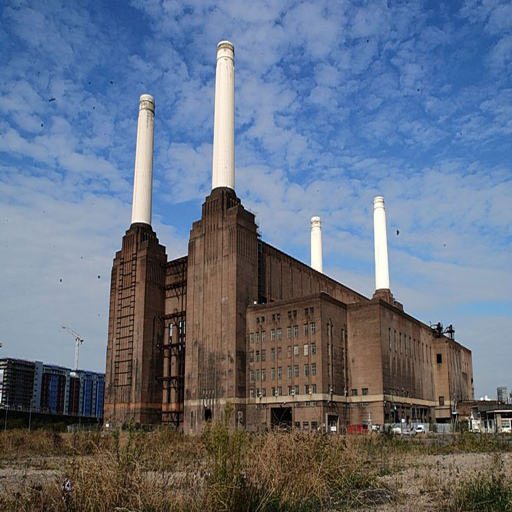

In [4]:
img1 = FastDownload().download('https://www.designingbuildings.co.uk/w/images/0/05/Battersea.jpg')
init_image1 = Image.open(img1).convert("RGB")
init_image1 = init_image1.resize((512, 512))
init_image1

In [6]:
#img2 = FastDownload().download('https://get.pxhere.com/photo/road-car-bicycle-rider-vehicle-motorcycle-trip-wanderlust-classic-motorcycling-bike-rider-royal-enfield-land-vehicle-507863.jpg')
#init_image2 = Image.open(img2).convert("RGB").resize((512, 512))
#init_image1 = init_image1.resize((512, 512))
#init_image2

Let's start off with Image 1 and define the reference text and the query text.

In [7]:
reference = "Old factory building"
query = "European castle"

Most of the code in this section comes from the `StableDiffusionImg2ImgPipeline`, which can be found in the diffusers library.

## Setup Pre-processing and Model Components

In [28]:
# Pre-process / prep the image
def preprocess(image):
  w, h = image.size
  # Resizing to an integer multiple of 32
  w, h = map(lambda x: x - x % 32, (w, h))
  # LANCZOS usually contributes to high quality output values.
  image = image.resize((w, h), resample=PIL.Image.Resampling.LANCZOS)
  image = np.array(image).astype(np.float32) / 255.0
  image = image[None].transpose(0, 3, 1, 2)
  image = torch.from_numpy(image)
  return 2.0 * image - 1.0

In [16]:
# Function to output text embeddings
def get_text_embeddings(prompt, negative_prompt, tokenizer,
                    text_encoder, do_classifier_free_guidance, device):
  # Prompt text embeddings
  text_inputs = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length,
                          return_tensors="pt", truncation=True)
  text_input_ids = text_inputs.input_ids
  text_embeddings = text_encoder(text_input_ids.to(device))[0]

  if negative_prompt is None:
    uncond_tokens = [""]
  else: # Here we will introduce conditionality to what used to be unconditional input tokens.
    uncond_tokens = negative_prompt
  max_length = text_input_ids.shape[-1]
  uncond_input = tokenizer(uncond_tokens, padding="max_length", max_length=max_length,
                           return_tensors="pt", truncation=True)
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [21]:
# Setup scheduler with timestamp callbacks
def get_timestamps(scheduler, num_inference_steps, strength, device):
  scheduler.set_timesteps(num_inference_steps)

  offset = scheduler.config.get("steps_offset", 0)
  init_timestep = int(num_inference_steps * strength) + offset
  init_timestep = min(init_timestep, num_inference_steps)

  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps], device=device)
  t_start = max(num_inference_steps - init_timestep + offset, 0)
  return timesteps, t_start

In [22]:
# Encode image into latents and scale
def encode_image(init_image, latents_dtype, device):
  init_image = preprocess(init_image)
  init_image = init_image.to(device=device, dtype=latents_dtype)
  with torch.no_grad(): init_latent_dist = vae.encode(init_image).latent_dist
  init_latents = init_latent_dist.sample(generator=generator)
  init_latents =  0.018215 * init_latents
  return init_latents

In [30]:
# Modifying the Img2Img Pipeline
def img2noise(init_image,
              prompt,
              mask=None,
              strength=0.5,
              num_inference_steps=50,
              guidance_scale=5,
              negative_prompt=None,
              generator=None,
              output_type="pil",
              return_dict=True,
              callback=None,
              callback_steps=1,
              device="cuda"):
  do_classifier_free_guidance = guidance_scale > 1.0
  text_embeddings = get_text_embeddings(prompt, negative_prompt, tokenizer, text_encoder,
                                        do_classifier_free_guidance, device)
  latents_dtype = text_embeddings.dtype
  timesteps, t_start= get_timestamps(scheduler, num_inference_steps, strength, device)

  # Encode init image into latents and scale the latents
  init_latents = encode_image(init_image, latents_dtype, device)

  # Add noise to the latents based on "timesteps"
  noise = torch.rand(init_latents.shape, generator=generator, device=device, dtype=latents_dtype)
  noisy_latents = scheduler.add_noise(init_latents, noise, timesteps)
  latents = noisy_latents

  # The recommended approach for optimization is to move the timesteps to the correct device
  # in advance
  timesteps = scheduler.timesteps[t_start:].to(device)
  noise_preds = torch.tensor([], device="cuda")

  # Training Loop
  for i, t in tqdm(enumerate(timesteps)):
    # Expand latents when doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
      noise_pred  = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    if do_classifier_free_guidance:
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Noise preds performance is better within the for loop
    noise_preds = torch.concat((noise_preds, noise_pred))
    # Compute previous noisy sample
    latent_step = scheduler.step(noise_pred, t, latents)
    latents = latent_step.prev_sample
    if mask is not None:
      latents = mask * latents + (1-mask)*init_latents

  latents = 1 / 0.18215 * latents
  with torch.no_grad(): image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images, noise_preds


## Estimate Noise Conditioned to Reference Text R

In [31]:
generator = torch.cuda.manual_seed(42)
reference_noises = torch.tensor([], device="cuda")
for _ in range(10):
  reference_pil, reference_noise = img2noise(init_image1, strength=0.5, prompt=reference, generator=generator)
  reference_noises = torch.concat([reference_noises, reference_noise])

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Estimate Noise Conditioned to Query Q